In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from datetime import datetime

from graph_gen import (
  lognorm_amount,
  populate,
  simulate,
  make_undirectional
)

from scores_gen import (
  generate_scores
)

%matplotlib inline
%config InlineBackend.figure_format='retina'


## Граф

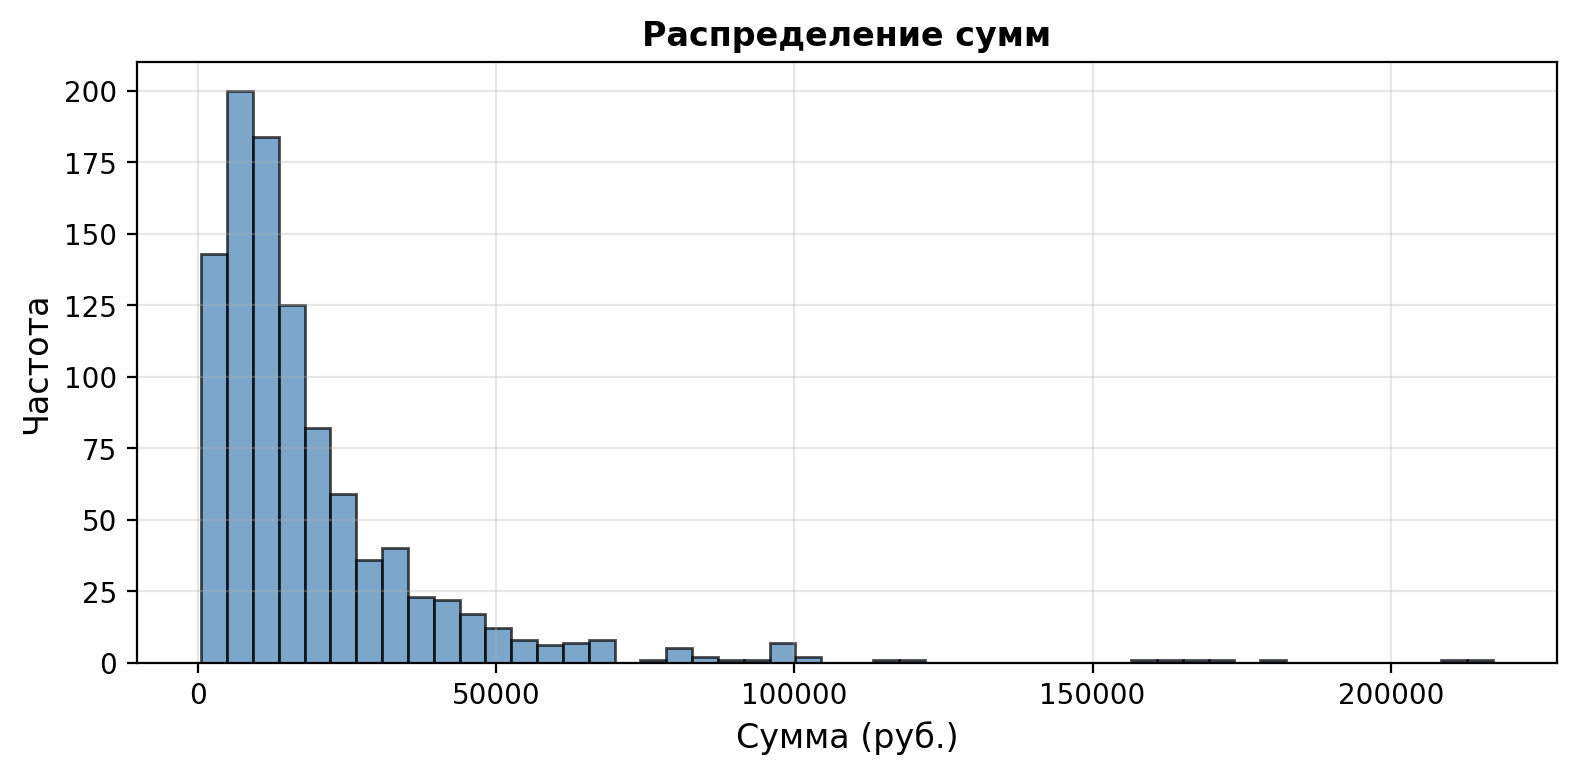

In [2]:
sums = []
for _ in range(1000):
  sums.append(lognorm_amount(
    min_rub=100.0, 
        mean_rub=20000.0, 
        sigma=0.9
  ))
  
plt.figure(figsize=(8, 4))
plt.hist(sums, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Сумма (руб.)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.title('Распределение сумм', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 1, 31)

p, h = populate(
  population=100,
  vender_frac=0.05
)

trx = simulate(
  people=p,
  households=h,
  start_date=start_date,
  end_date=end_date,
  noise_rate=0.005
)

df = make_undirectional(trx)

df.head()

,src,dst,timestamp,amount
0,2,98,2025-01-01 08:26:27,274193.884610
1,59,51,2025-01-01 13:43:19,160271.625746
2,91,60,2025-01-01 13:47:01,166414.964165
3,66,95,2025-01-01 14:09:52,345129.756590
4,24,48,2025-01-01 14:43:53,7996.870344


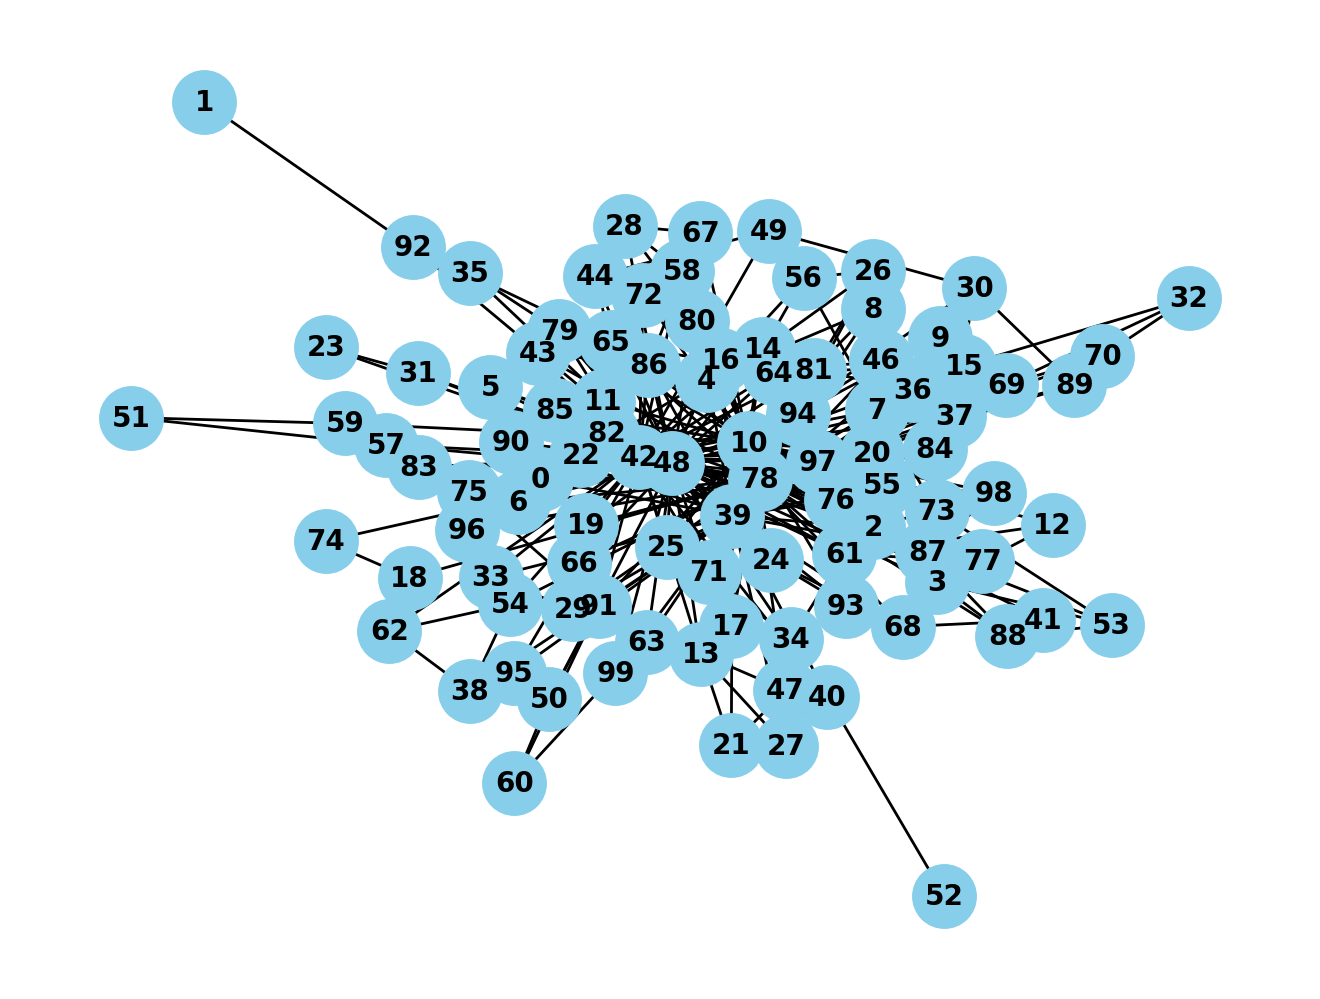

In [9]:
g = nx.from_pandas_edgelist(df=df, source='src', target='dst', edge_attr='amount')
pos = nx.spring_layout(g)
nx.draw(
  g, 
  pos, 
  with_labels=True, 
  node_size=500, 
  node_color='skyblue', 
  font_size=10, 
  font_weight='bold'
)


In [163]:
set(df.query('src == 58 or dst == 58')[['src','dst']].values.flat) - set([58])

{np.int64(47), np.int64(69), np.int64(72), np.int64(89)}

## Граф из файла

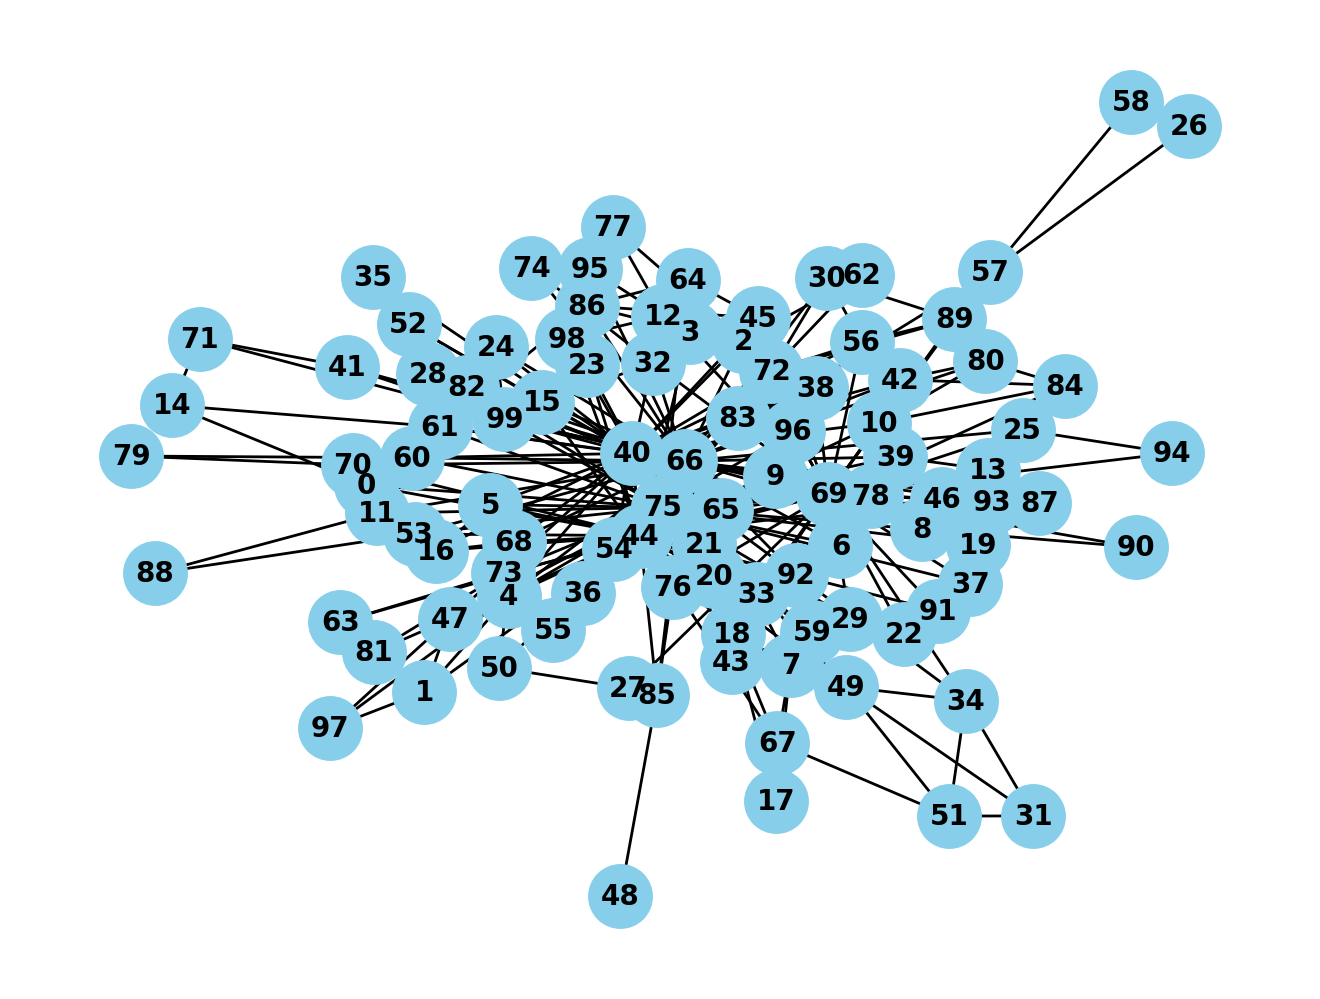

In [2]:
df_graph = pd.read_csv('data/transactions.csv')
g = nx.from_pandas_edgelist(df=df_graph, source='src', target='dst', edge_attr='amount')
pos = nx.spring_layout(g)
nx.draw(
  g, 
  pos, 
  with_labels=True, 
  node_size=500, 
  node_color='skyblue', 
  font_size=10, 
  font_weight='bold'
)


## Скоринги

In [3]:
from utils import load_scores, load_pk, load_sk

pk = load_pk('keys/pk.json')
sk = load_sk('keys/sk.json', pk)
scores = load_scores(load_pk('keys/pk.json'), 'data/scores.csv')
df_scores = pd.read_csv('data/scores.csv')

In [4]:
pid = 56

friends = list(set(df_graph.query(f'src == {pid} or dst == {pid}')[['src','dst']].values.flat) - set([pid]))

print(f'friends = {[int(i) for i in friends]}')

if len(friends) > 0:
  env_score = scores[friends[0]]
  for friend in friends[1:]:
    env_score += scores[friend]
  

  plain_sum = df_scores.query(f'pid == @friends')['score_plain'].sum()
  print(f'plain = {plain_sum}')
  print(f'decrypted = {sk.decrypt(env_score)}')


friends = [69, 40, 72, 89, 30]
plain = 12
decrypted = 12


## Эксперименты

In [5]:
from phe import paillier

from bank import Bank
from payment_service import PaymentService  

bank = Bank(
  pk_path='keys/pk.json',
  sk_path='keys/sk.json',
  scores_path='data/scores.csv'
)

payment_service = PaymentService(
  pk_path='keys/pk.json',
  graph_path='data/transactions.csv',
  scores_path='data/scores.csv'
)

In [6]:
bank.decrypt(
  payment_service.simple_query(pid)
)

12

## PIR

### Гомоморфное Шифрование

In [7]:
enc_score = payment_service.simple_query(pid)
print(enc_score.ciphertext())
print(bank.decrypt(enc_score))

6240414476093416467637377229912066358932182570869292495513634050095332325658256966243812183098766780910761426041972129660221984183853299281093255967690363549127870331034402819927410248649975839080668446651224939877746754694042154730799585622096698596552797624975833373497207564610317301504740782516159760058158136991772238315031232595164363841055532464039892858489538772464564166098909583056142040171473907804441978905568997723297498803930108191637005605444763312021031052719421416370066254635955695727866110013569966373182408183133566533174469815203250321916917442977397841653244565067361095906404194933379941622598971651428681844125637741003186611190850202684420838130173861356175634468400767029261457756975850312941683483853305135702072277565512081940987208289875876885810943119786392208688835877028739386221421448501518159376107086100205487671816752530606894116051326936142779987130910177019221986901714983729242630260736653022021306358272479870022672919043042044848120068740457804661016304229266

In [8]:
pir_query = bank.make_pir_query_ahe(pid)

func "make_pir_query_ahe" took 1 minute and 13.1847 seconds to execute.


In [9]:
result = payment_service.pir_ahe_query(pir_query)

func "pir_ahe_query" took 1 minute and 25.6041 seconds to execute.


In [10]:
bank.decrypt_ahe(result)

12

In [17]:
e1 = bank.skx.decrypt(result)
e2 = bank.sk.decrypt(paillier.EncryptedNumber(
  public_key=bank.pk,
  ciphertext=e1
))
print(e2)

12


## Маскирование

In [11]:
pir_query = bank.make_pir_query(pid)

func "make_pir_query" took 9.8395 seconds to execute.


In [12]:
masked_scores = payment_service.get_masked_env_scores()

In [13]:
enc_mask = payment_service.pir_query(pir_query)

func "pir_query" took 0.4725 seconds to execute.


In [14]:
bank.decrypt_pir(masked_scores[pid], enc_mask)

12

In [ ]:
import sys
import random
from phe import paillier

pk, sk = paillier.generate_paillier_keypair(n_length=2048)

e10 = pk.encrypt(10)
e20 = pk.encrypt(20)
e0 = pk.encrypt(0)
e1 = pk.encrypt(1)

s1 = e10 + e20

print(s1.ciphertext())

print()

mask =random.randint(-sys.maxsize, sys.maxsize)

ex = e10 + mask

print(sk.decrypt((ex)))



3173418152722107333974596895043337958132965322042977448562903149475171195525597616146151968919446752220117918646030064159647377152258933704633553950360902877622874840111390284167923071574561425453829340956974725358580446351095133488468832763323852262528369476752695220786298987411436110958406095498765938150569652156452266723744840364112958712125649405552772508089120884590632529103577171666882738845230060618055914612310085016301431892306771628964724873073905081504684638769912182496432260401350919802096667527522683103759332398499396176019171772521419395981408945001212999803045464913933054881578037295439536520284975876205346642534020163852947390509130523150606476810560085321517618171508190060513190954908086171692208462960433653643284275794982936016394045496492979142862550501413784468065656450294795785100870338425040652308199649256064829780083070430172704701681121229329359875164487206080420004672421975045449987477782433291798609662497408229999568430964597580874061093434817385255835495515627

In [ ]:
for i in range(10):
  mask = random.randint(-sys.maxsize, sys.maxsize)
  ex = e10 + mask
  print(sk.decrypt((ex - mask)))


10
10
10
10
10
10
10
10
10
10


In [15]:
idx = 42
masks = []
idx_vec = []
for i in range(100):
  masks.append(random.randint(-sys.maxsize, sys.maxsize))
  if i == idx:
    idx_vec.append(pk.encrypt(1))
  else:
    idx_vec.append(pk.encrypt(0)) 

In [16]:
masks[42]

2578244867052856671

In [17]:
s = pk.encrypt(0)
for i in range(len(masks)):
  s += masks[i] * idx_vec[i]

sk.decrypt(s)-masks[42]

0

In [18]:
import math
from phe import paillier

pkx, skx = paillier.generate_paillier_keypair(n_length=4112)
pk, sk = paillier.generate_paillier_keypair(n_length=2048)

e42 = pk.encrypt(42)
e1 = pkx.encrypt(1)
e0 = pkx.encrypt(0)

ee = e42.ciphertext() * e1 + e42.ciphertext() * e0

In [19]:
#sk.decrypt(paillier.EncryptedNumber(pk, skx.decrypt(ee)))
int(math.log2(pk.n*3)*2)

4097

In [20]:
e42 = pk.encrypt(42)
e1 = pkx.encrypt(1)
e0 = pkx.encrypt(0)

ee = e42.ciphertext() * e1 + e42.ciphertext() * e0

In [21]:
pkx, skx = paillier.generate_paillier_keypair(n_length=64)

if pkx.n:
  n = pkx.n // 3
  print(math.log2(n)-1)


60.7909843022572
